In [21]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns

from ISLP import load_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from ISLP import confusion_table

### 14. In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

In [22]:
# Load Auto dataset
Auto = load_data('Auto')

# Drop missing values
Auto = Auto.dropna()

Auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 27.7+ KB


#### (a) Create a binary variable, ``mpg01``, that contains a 1 if ``mpg`` contains a value above its median, and a 0 if ``mpg`` contains a value below its median. You can compute the median using the ``median()`` method of the data frame. Note you may find it helpful to add a column ``mpg01`` to the data frame by assignment. Assuming you have stored the data frame as Auto, this can be done as follows:

In [23]:
mpg_median = Auto["mpg"].median()

# Creates a binary variable "mpg01", that is 1 (high mileage) if mpg is above the median, and 0 (low mileage) if mpg is below
Auto["mpg01"] = np.where(Auto["mpg"] > mpg_median, 1, 0)

#### (b) Explore the data graphically in order to investigate the association between ``mpg01`` and the other features. Which of the other features seem most likely to be useful in predicting ``mpg01``? Scatterplots and boxplots may be useful tools to answer this question. Describe your findings

Since the variable ``mpg01`` is binary, scatterplots are not very informative, so we can visualize continuous predictors using boxplots and count plots for categorical predictor.

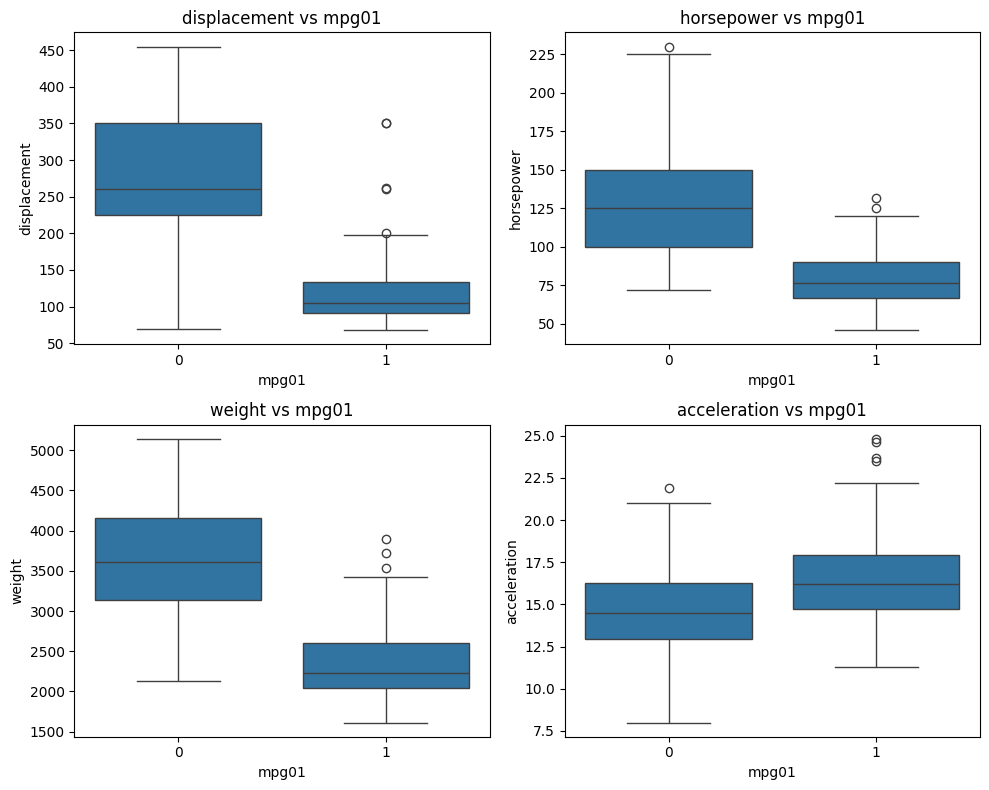

In [24]:
# Select numeric features to compare with "mpg01"
features = ['displacement', 'horsepower', 'weight', 'acceleration']

fig, axes = plt.subplots(2, 2, figsize=(10,8))
axes = axes.flatten() 

# Loops through each selected feature and creates boxplots with "mpg01"
for i, feature in enumerate(features):
    sns.boxplot(x='mpg01', y=feature, data=Auto, ax=axes[i])
    axes[i].set_title(f'{feature} vs mpg01')

plt.tight_layout()
plt.show()

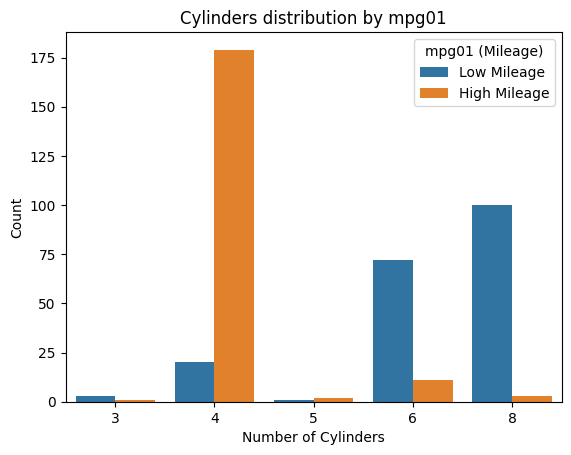

In [25]:
# Count of each cylinder category for each mpg01 class
sns.countplot(x="cylinders", hue="mpg01", data=Auto)
plt.title("Cylinders distribution by mpg01")
plt.xlabel("Number of Cylinders")
plt.ylabel("Count")
plt.legend(title="mpg01 (Mileage)", labels=["Low Mileage", "High Mileage"])
plt.show()

From the boxplots, we observe that cars with high mpg (mpg01 = 1 → high mileage) generally have smaller displacement, lower horsepower, and lighter weight, while cars with low mpg (mpg01 = 0 → low mileage) have larger displacement, higher horsepower, and heavier weight. Acceleration (Time (sec) to accelerate from 0 to 60 mph) shows the opposite, with high mileage cars having slightly higher acceleration time than low mileage cars.

Most high mileage cars have 4 cylinders, while most low mileage cars have 6 or 8 cylinders. Fewer cylinders $\implies$ higher mpg, More cylinders $\implies$ lower mpg.

#### (c) Split the data into a training set and a test set.

In [26]:
# Define predictor and target variable
X = Auto[['displacement', 'horsepower', 'weight', 'cylinders', 'acceleration']]
y = Auto['mpg01']

# Split the data into training and test sets (80% train, 20% test)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [27]:
# Standardize the features to have mean 0 and standard deviation 1
scaler = StandardScaler(with_mean=True, with_std=True, copy=True)
scaler.fit(X)
X_std = scaler.transform(X)

feature_std = pd.DataFrame(X_std, columns=X.columns)

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(feature_std, y, test_size=0.2, random_state=123)

#### (h) Perform KNN on the training data, with several values of K, in order to predict ``mpg01``. Use only the variables that seemed most associated with ``mpg01`` in (b). What test errors do you obtain? Which value of K seems to perform the best on this data set?

In [28]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
knn1_pred = knn1.predict(X_test)
    
test_error1 = np.mean(y_test != knn1_pred)
    
C = confusion_table(knn1_pred, y_test)

print("Test Error:", round(test_error1, 3))
print("\nConfusion Table:")
print(C)
    

Test Error: 0.139

Confusion Table:
Truth       0   1
Predicted        
0          37   5
1           6  31


In [29]:
test_errors = []
k_val = range(1, 11)

# Loop over different k values and display accuracy for mpg01 = 1 and mpg01 = 0
for K in k_val:
    # Fit KNN
    knn = KNeighborsClassifier(n_neighbors=K)
    knn_pred = knn.fit(X_train, y_train).predict(X_test)
    
    # Confusion table
    C = confusion_table(knn_pred, y_test)

    # Overall test error
    test_error = np.mean(knn_pred != y_test)
    test_errors.append(test_error)
    
    # High mpg (1)
    pred_high = C.loc[:, 1].sum()
    did_high = C.loc[1, 1]
    acc_high = did_high / pred_high if pred_high > 0 else 0
    
    # Low mpg (0)
    pred_low = C.loc[:, 0].sum()
    did_low = C.loc[0, 0]
    acc_low = did_low / pred_low if pred_low > 0 else 0
    
    print(f"K = {K}")
    print(f"Test Error: {test_error:.3f}")
    print(f"High mpg (1): predicted {pred_high}, correct {did_high}, accuracy {acc_high:.1%}")
    print(f"Low mpg  (0): predicted {pred_low}, correct {did_low}, accuracy {acc_low:.1%}")

K = 1
Test Error: 0.139
High mpg (1): predicted 36, correct 31, accuracy 86.1%
Low mpg  (0): predicted 43, correct 37, accuracy 86.0%
K = 2
Test Error: 0.114
High mpg (1): predicted 36, correct 31, accuracy 86.1%
Low mpg  (0): predicted 43, correct 39, accuracy 90.7%
K = 3
Test Error: 0.114
High mpg (1): predicted 36, correct 33, accuracy 91.7%
Low mpg  (0): predicted 43, correct 37, accuracy 86.0%
K = 4
Test Error: 0.114
High mpg (1): predicted 36, correct 32, accuracy 88.9%
Low mpg  (0): predicted 43, correct 38, accuracy 88.4%
K = 5
Test Error: 0.127
High mpg (1): predicted 36, correct 32, accuracy 88.9%
Low mpg  (0): predicted 43, correct 37, accuracy 86.0%
K = 6
Test Error: 0.139
High mpg (1): predicted 36, correct 31, accuracy 86.1%
Low mpg  (0): predicted 43, correct 37, accuracy 86.0%
K = 7
Test Error: 0.139
High mpg (1): predicted 36, correct 32, accuracy 88.9%
Low mpg  (0): predicted 43, correct 36, accuracy 83.7%
K = 8
Test Error: 0.139
High mpg (1): predicted 36, correct 31

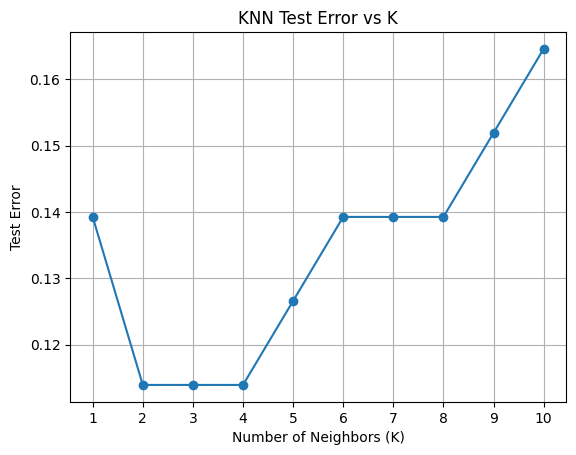

In [30]:
# Plot KNN test error vs K
plt.plot(k_val, test_errors, marker='o')
plt.xticks(k_val)
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Test Error")
plt.title("KNN Test Error vs K")
plt.grid(True)
plt.show()


For the KNN classifier, I initially fitted using the features most strongly associated with ``mpg01``: displacement, horsepower, weight, and cylinders. Acceleration was excluded because the boxplots showed only a small difference.

Using these four features, the overall test error was lowest ($\approx$ 0.127) for K = 1, 3 and 4, with K = 3 providing a good balance between predicting high mpg and low mpg cars.

Adding acceleration to the feature slightly improved the test error, lowering it to ≈0.114 for K = 2, 3 and 4 with K = 4 giving a balanced performance across both classes.

**Conclusion**: K=4 seems to perform best with test error $\approx$ 0.114, for predict high or low mpg based on displacement, horsepower, weight, cylinders, and acceleration.